Primeiro vamos importar as bibliotecas a serem utilizadas

In [501]:
import pandas as pd
import numpy as np
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy import stats
from numpy import array
from tensorflow import keras # for building Neural Networks
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, SimpleRNN # for creating regular densely-connected NN layers and RNN layers
import math # to help with data reshaping of the data
import sklearn # for model evaluation
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import mean_squared_error # for model evaluation metrics
from sklearn.preprocessing import MinMaxScaler # for feature scaling
import plotly 
import plotly.express as px
import plotly.graph_objects as go



A partir daqui, já temos os dados gerados pelo código data_generation.ipynb
Nós vamos ler esses dados, e mostrar já os primeiros 5 valores para termos uma noção

In [502]:

df = pd.read_csv('q_cond.csv', index_col=0)
df.head()

,q_cond,k,dT_dx
0,-1.0,1.0,1.0
1,-2.0,2.0,1.0
2,-3.0,3.0,1.0
3,-4.0,4.0,1.0
4,-2.0,1.0,2.0


Vamos agora, dar uma olhada na dispersão dos dados para entender como eles estão se comportando

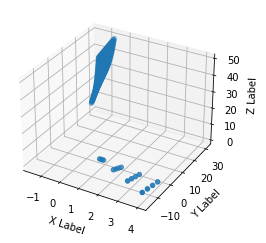

In [503]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.scatter(df['k'], df['q_cond'], df['dT_dx'])
plt.show()

Aqui fica difícil descobrir qualquer relação entre os dados, podemos tentar analisar estes dados em duas dimensões também, mas para isso vamos precisar realizar uma transformação, que neste caso será: *k x dT_dx*, assim podemos tentar encontrar outras relações entre os dados

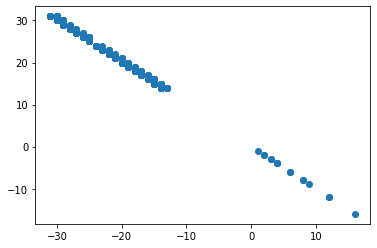

In [504]:
from cmath import sqrt


y = df.loc[:,'q_cond'].to_numpy()
x = df.apply(lambda row: row.k * row.dT_dx, axis=1).to_numpy()
x = np.int64(x)
plt.scatter(x, y)
plt.show()

Por este gráfico fica bastante clara a relação entre os dados, estamos observando uma reta, que apesar de depender de duas variáveis, pode ser traduzida para o formato *ax + b*, onde *b = 0*

A partir desta observação, já fica claro qual modelo devemos utilizar para realizar a predição: O modelo de regressão linear, vamos ver como fica?

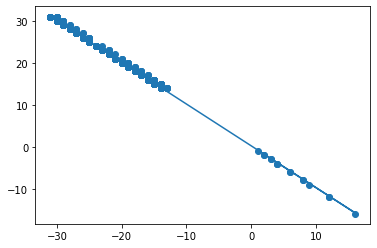

In [505]:
slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

Como a reta conseguiu se ajustar com precisão para todos os pontos, já podemos concluir que indepententemente do valor da relação de *k x dT_dx* 
Vamos tentar para o valor de -1000

In [506]:
teste = myfunc(-1000)
print(teste)

995.8817724249134


Como sabemos o valor real da função, podemos calcular e comparar os resultados
q_cond = -k*dT_dx, onde -k*dT_dx = -1000

In [507]:
q_cond = -1*-1000
print(q_cond)


1000


E agora podemos calcular os valores para analisar o quanto o modelo desempenhou em relação ao valor verdadeiro, e determinar sua precisão

In [508]:
val = q_cond - teste
print(val)
score = 100 - (val/teste * 100)
print('Precisão é de {}'.format(score))

4.118227575086621
Precisão é de 99.58647424934198


Agora, e se não fosse descoberta esta relação linear? Haveria alguma outra forma de realizar a predição?
Seria possível, neste caso vamos tentar analisar as relações de k e dT_dx apenas com o conjunto de dados disponível.

In [509]:
from sklearn.model_selection import train_test_split



X = df.loc[:, ['k', 'dT_dx']].to_numpy()
y = df.loc[:,'q_cond'].to_numpy()
print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

[[ 1.          1.        ]
 [ 2.          1.        ]
 [ 3.          1.        ]
 ...
 [-0.59183673 49.        ]
 [-0.6122449  49.        ]
 [-0.63265306 49.        ]]


In [510]:

model = Sequential(name="First-RNN-Model") 
model.add(Input(shape=(2, 1), name='Input-Layer'))
model.add(SimpleRNN(units=10, activation='tanh', name='Hidden-Recurrent-Layer')) 
model.add(Dense(units=10, activation='tanh', name='Hidden-Layer')) 
model.add(Dense(units=1, activation='linear', name='Output-Layer')) 

model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], 
             )

model.fit(X_train, 
          y_train, 
          batch_size=1,
          epochs=10, 
          verbose='0', 
)


pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("")
print('-------------------- Model Summary --------------------')
model.summary()

print('---------- Evaluation on Test Data ----------')
print("MSE: ", mean_squared_error(y_test, pred_test))
print("")

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
7/7 [==============================] - 0s 833us/step

-------------------- Model Summary --------------------
Model: "First-RNN-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Recurrent-Layer (Sim  (None, 10)               120       
 pleRNN)                                                         
                                                                 
 Hidden-Layer (Dense)        (None, 10)                110       
                                                                 
 Output-Layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________
---------- Evaluation on Test 

Agora que treinamos o modelo, vamos comparar os resultados originais (em azul) com os resultados que foram previstos (em laranja)

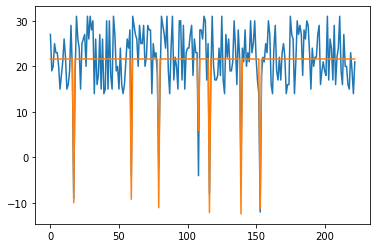

In [511]:
plt.plot(y_test)
plt.plot(pred_test)

O que podemos observar aqui, é que o modelo foi capaz de realizar boas predições para valores de q_cond, inferiores a 16, porém os valores superiores foram horríveis, o que inviabilizaria o modelo.

Conclusão:

Apesar de redes neurais serem excelentes para vários tipos de predições, a predição numérica neste caso ficou bem abaixo de uma regressão linear, um modelo que tem aplicações bem mais restritas. Entretanto acredito não ter explorado diversos parâmetros de redes neurais que com certeza ajudariam a realizar predições muito mais eficazes.